In [1]:
%%capture

!pip install category_encoders==2.*
!pip install eli5 pdpbox shap

import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt

import category_encoders as ce

from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from category_encoders import OrdinalEncoder, OneHotEncoder

from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier 
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

from sklearn.inspection import permutation_importance
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBClassifier
from xgboost import XGBRegressor

from pdpbox.pdp import pdp_interact, pdp_interact_plot, pdp_isolate, pdp_plot
from shap import TreeExplainer, initjs, force_plot

In [2]:
url = 'https://raw.githubusercontent.com/WaqasKhwaja/Female-Death-Probability/main/Datasets/UNdata_Export_20210222_174651093.csv'
df = pd.read_csv(url)
df.head()

Country or Area  Year   Area  ... Source Year Value Value Footnotes
0         Andorra  2015  Total  ...      2018.0   5.0             NaN
1         Andorra  2015  Total  ...      2018.0   0.0             NaN
2         Andorra  2015  Total  ...      2018.0   0.0             NaN
3         Andorra  2015  Total  ...      2018.0   0.0             NaN
4         Andorra  2015  Total  ...      2018.0   0.0             NaN

[5 rows x 11 columns]

# Clean Dataframe

- Drop high-cardinality columns unless data is dependent on it. Also, drop any singular constant valued columns.

In [ ]:
df = df[~df['Year'].isin(['Footnote','The code is C.'])]
df = df.drop(columns=['Source Year', 'Value Footnotes', 'Reliability', 'Area'])
df = df.rename(columns={'Country or Area': 'Country', 'Cause of death (WHO)': 'Death_Cause', 'Record Type': 'Record'})
df = df.set_index(df['Year'].astype(int))
print(df.index.dtype)
df.head()

int64


Country  Year   Sex    Age  \
Year                               
2015  Andorra  2015  Male  Total   
2015  Andorra  2015  Male  Total   
2015  Andorra  2015  Male  Total   
2015  Andorra  2015  Male  Total   
2015  Andorra  2015  Male  Total   

                                           Death_Cause  \
Year                                                     
2015  Certain infectious and parasitic diseases, ICD10   
2015             Intestinal infectious diseases, ICD10   
2015                               Tuberculosis, ICD10   
2015                                    Tetanus, ICD10   
2015                                 Diphtheria, ICD10   

                                    Record  Value  
Year                                               
2015  Data tabulated by year of occurrence    5.0  
2015  Data tabulated by year of occurrence    0.0  
2015  Data tabulated by year of occurrence    0.0  
2015  Data tabulated by year of occurrence    0.0  
2015  Data tabulated by year of occurrence    0.0

## Choose Target Variable & Find Baseline Accuracy

In [ ]:
target = 'Death_Cause'
y = df[target]
X = df.drop(columns=target)

mask1 = X.index < 2000 
mask2 = X.index > 2000

X_train, y_train = X.loc[mask1], y.loc[mask1]
X_val, y_val = X.loc[mask2], y.loc[mask2]

print("Baseline Accuracy = ", y_train.value_counts(normalize=True).max())

Baseline Accuracy =  0.014471243042671614


## Running Searches 

- Find the best parameters using searches to make model.

In [ ]:
estimator = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(random_state=42)
)

params = {
    'simpleimputer__strategy': ['mean', 'median'],
    'randomforestclassifier__n_estimators': [25, 50, 75, 100, 125, 150, 175, 200],
    'randomforestclassifier__max_depth': range(5, 36, 5)
}

random = RandomizedSearchCV(
    estimator,
    param_distributions=params,
    n_iter=25,
    cv=10,
    n_jobs=-1,
    verbose=1
)

# random.fit(X_train, y_train)

# print(random.best_params_)
# print(random.best_score_)

## Making Models

In [ ]:
forest = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=25, max_depth=25, random_state=42)
)

forest.fit(X_train, y_train);

forest_acc = forest.score(X_train, y_train)

print('Base Tree Model Accuracy:', forest.score(X_val, y_val))
print('Forest Training Accuracy Score:', forest_acc)

Base Tree Model Accuracy: 0.10097606465651228
Forest Training Accuracy Score: 0.6024118738404453


In [ ]:
linear = lr = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(), 
    StandardScaler(), 
    LogisticRegressionCV(multi_class='auto', solver='lbfgs', cv=5, n_jobs=-1)
)

lr.fit(X_train, y_train)

print('Logistic Regression Model Accuracy:', lr.score(X_val, y_val))

Logistic Regression Model Accuracy: 0.034417158843643145


In [ ]:
GB = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(strategy='median'),
                         GradientBoostingClassifier(learning_rate=0.2, n_estimators=25, random_state=42))

GB.fit(X_train, y_train);

print('Gradient Boosting Model Accuracy:', GB.score(X_val, y_val))

Gradient Boosting Model Accuracy: 0.06475598383587193


In [ ]:
XG = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(strategy='median'),
                         XGBClassifier(learning_rate=0.2, n_estimators=25, random_state=42))

XG.fit(X_train, y_train);

print('XGBoosting Model Accuracy:', XG.score(X_val, y_val))

[19:07:34] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoosting Model Accuracy: 0.0929686042897109


## Plotting Importances

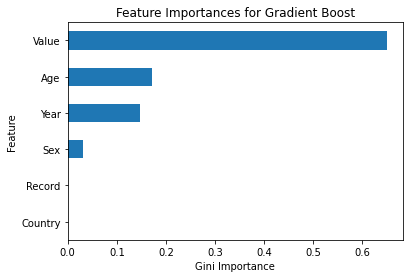

In [ ]:
importances = GB.named_steps['gradientboostingclassifier'].feature_importances_
features = X_train.columns

feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for Gradient Boost');

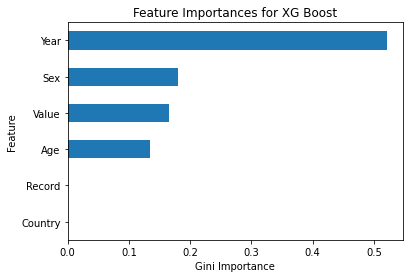

In [ ]:
importances = XG.named_steps['xgbclassifier'].feature_importances_
features = X_train.columns

feat_imp = pd.Series(importances, index=features).sort_values()
feat_imp.tail(10).plot(kind='barh')
plt.xlabel('Gini Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for XG Boost');

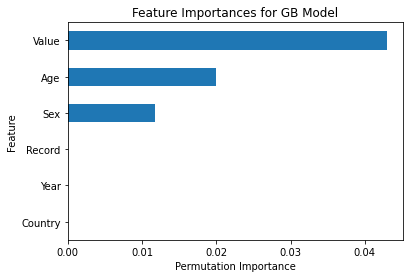

In [ ]:
perm_imp = permutation_importance(GB,
                                  X_val, 
                                  y_val, 
                                  n_jobs=10, 
                                  random_state=42)

data = pd.DataFrame({'importances_mean': perm_imp['importances_mean']}, index = X_val.columns)

data['importances_mean'].sort_values().tail(10).plot(kind='barh')
plt.xlabel('Permutation Importance')
plt.ylabel('Feature')
plt.title('Feature Importances for GB Model');

## PDP Plots

- PDP require to use the model outside pipeline, therefore, you use Ordinal Encoder outside of a pipeline, to encode your data first. 
- Then use the encoded data with pdpbox. After using the SimpleImputer, the train dataset is no longer a dataframe, but a series.
- PDP does not accept series. Therefore, we should use fillna to do the fill null value work. (Use fillna instead of SimpleImputer)

- Sex includes Male, Female, and Unknown.

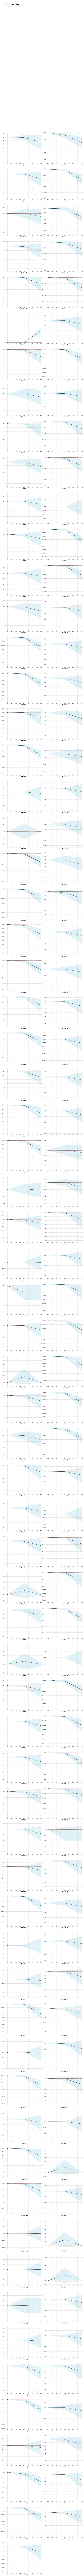

In [ ]:
oe = OrdinalEncoder()

X_train_T = oe.fit_transform(X_train)

X_train_T[X_train_T.columns] = X_train_T[X_train_T.columns].apply(pd.to_numeric, errors='coerce')
X_train_TT = X_train_T.fillna(X_train_T.median())

GB =  GradientBoostingClassifier(learning_rate=0.2, n_estimators=25, random_state=42)
GB.fit(X_train_TT, y_train);

X_val_T = oe.transform(X_val)
X_val_T[X_val_T.columns] = X_val_T[X_val_T.columns].apply(pd.to_numeric, errors='coerce')
X_val_TT = X_val_T.fillna(X_val_T.median())

feature = 'Sex'

isolate = pdp_isolate(
          model = GB,
          dataset = X_val_TT,
          model_features = X_val.columns,
          feature = feature
)
pdp_plot(isolate, feature_name=feature);

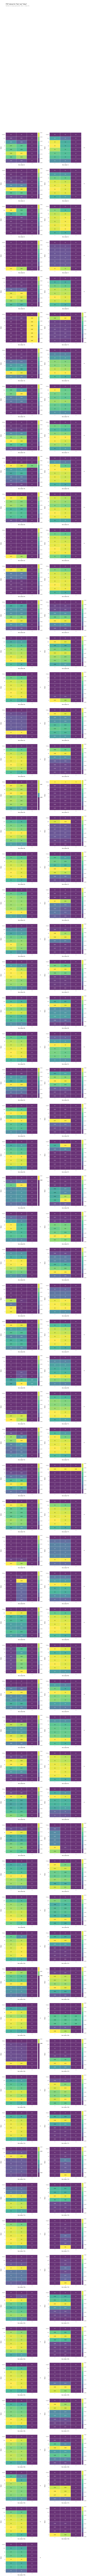

In [ ]:
features = ['Sex','Value']

interact = pdp_interact(
          model = GB,
          dataset = X_val_TT,
          model_features = X_val.columns,
          features = features
)
pdp_interact_plot(interact, plot_type ='grid', feature_names = features);

### Classification Report

In [ ]:
cr = classification_report(y_val,
                            forest.predict(X_val))

print(cr)

                                                                                                      precision    recall  f1-score   support

                                                           Accidental drowning and submersion, ICD10       0.06      0.06      0.06      1229
                                   Accidental poisoning by and exposure to noxious substances, ICD10       0.06      0.07      0.06      1229
                                                                                    Accidents, ICD10       0.29      0.25      0.27      1221
                                                                          Acute poliomyelitis, ICD10       0.08      0.12      0.10      1230
                                   Acute rheumatic fever and chronic rheumatic heart diseases, ICD10       0.04      0.05      0.05      1229
                                                                                   All causes, ICD10       0.93      0.75      0.83      1817
     

## Predictions

In [ ]:
forest_pred = forest.predict(X_val)
Predictions = pd.DataFrame({'Death_Cause': forest_pred}, index=X_val.index)
Predictions

Death_Cause
Year                                                   
2015                              Whooping cough, ICD10
2015                         Acute poliomyelitis, ICD10
2015                         Acute poliomyelitis, ICD10
2015                         Acute poliomyelitis, ICD10
2015                         Acute poliomyelitis, ICD10
...                                                 ...
2012               Other direct obstetric causes, ICD10
2012                                     Tetanus, ICD10
2012  Diseases of the musculoskeletal system and con...
2012               Other direct obstetric causes, ICD10
2012               Other direct obstetric causes, ICD10

[80425 rows x 1 columns]